In [162]:
import pickle
import warnings
import gzip
import random
import ujson

import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict, defaultdict
from scipy import stats
from scipy.spatial import distance
from itertools import combinations
from sklearn import preprocessing

from torch.nn import functional as F

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 500

In [54]:
preds = []

for path in tqdm(glob('../data/embeds-en/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            line.pop('embedding')
            preds.append(OrderedDict(title=title, **line))

100%|██████████| 65/65 [00:24<00:00,  2.68it/s]


In [55]:
domains = list(set([r['label'] for r in preds]))

In [56]:
domains

['apnews.com',
 'wsj.com',
 'buzzfeed.com',
 'thehill.com',
 'cnn.com',
 'nytimes.com',
 'dailykos.com',
 'dailycaller.com',
 'bloomberg.com',
 'washingtonpost.com',
 'huffingtonpost.com',
 'foxnews.com',
 'breitbart.com']

In [67]:
def title_dist(domain):

    weights = np.array([
        [r[f'p_{d}'] if d != domain else 0 for d in domains]
        for r in preds if r['label'] == domain
    ])

    return weights.sum(0) / weights.sum()

In [68]:
title_dist('nytimes.com')

array([0.16617034, 0.11970994, 0.02137788, 0.0613027 , 0.09278207,
       0.        , 0.05339999, 0.04187255, 0.08532784, 0.10671388,
       0.08059927, 0.11149191, 0.05925162])

In [66]:
actors = defaultdict(set)

for path in tqdm(glob('../data/link-actor-graph.json/*.gz')):
    with gzip.open(path, 'rb') as fh:
        for line in fh:
            r = ujson.loads(line)
            actors[r['domain']].add(r['actor_id'])

100%|██████████| 10/10 [00:37<00:00,  3.75s/it]


In [69]:
def jaccard_sim(d1, d2):
    
    d1a = actors[d1]
    d2a = actors[d2]
    
    return (
        len(set.intersection(d1a, d2a)) /
        len(set.union(d1a, d2a))
    )

In [76]:
def actor_dist(domain):
    
    sims = np.array([
        jaccard_sim(domain, d2)
        if d2 != domain else 0
        for d2 in domains
    ])

    return sims / sims.sum()

In [79]:
actor_dist('nytimes.com')

array([0.08224068, 0.0875655 , 0.07723169, 0.11976764, 0.12260452,
       0.        , 0.03148602, 0.03879609, 0.08190896, 0.14940651,
       0.09919566, 0.06992678, 0.03986996])

In [191]:
rows = []
for d1, d2 in tqdm(combinations(domains, 2)):
    d = jaccard_sim(d1, d2)
    rows.append((d1, d2, d))

78it [00:45,  2.86it/s]


In [197]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'd'))
df['label'] = df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

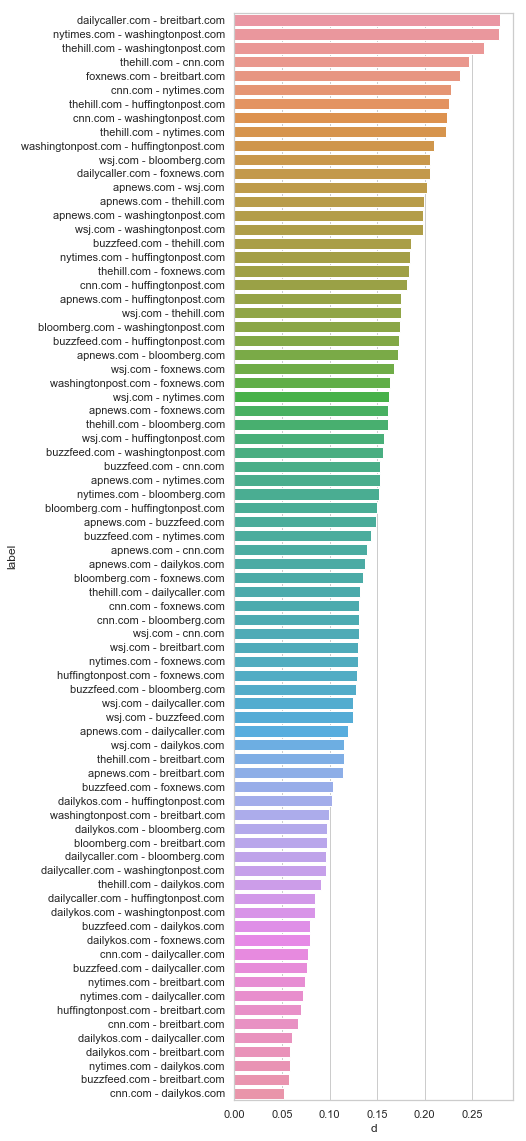

In [198]:
plt.figure(figsize=(5,20))
sns.barplot(x='d', y='label', data=df.sort_values('d', ascending=False))

# Renormalized masses

In [91]:
rows = []
for d1 in tqdm(domains):
    dist = title_dist(d1)
    for d2, m in zip(domains, dist):
        if d1 != d2:
            rows.append((d1, d2, m))

100%|██████████| 13/13 [00:09<00:00,  1.84it/s]


In [108]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'm'))
df['label'] = df[['d1', 'd2']].apply(lambda x: f'{x[0]} -> {x[1]}', axis=1)

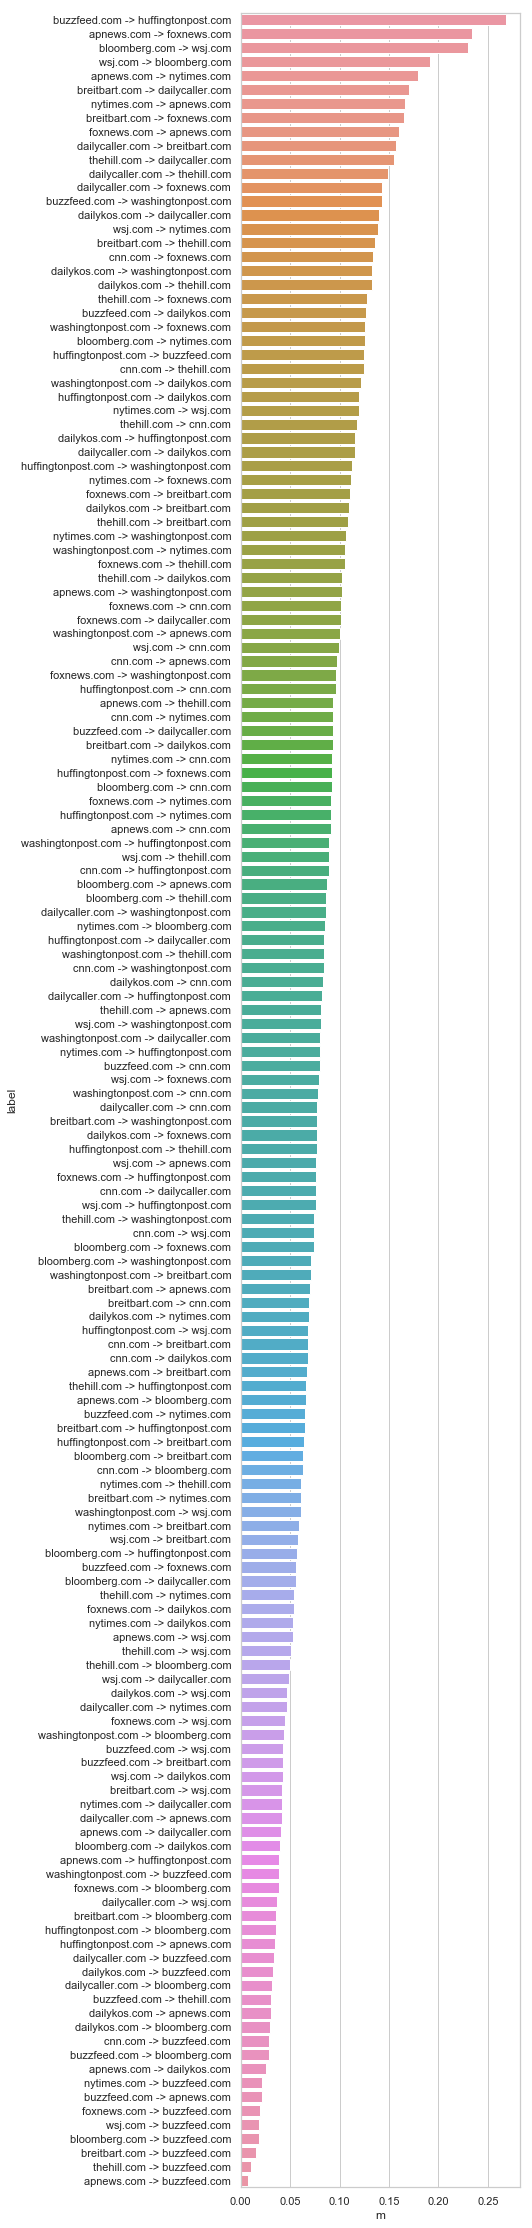

In [114]:
plt.figure(figsize=(5,40))
sns.barplot(x='m', y='label', data=df.sort_values('m', ascending=False))

In [180]:
def title_corr(d1, d2, metric):
    
    d1p = [r[f'p_{d1}'] for r in preds]
    d2p = [r[f'p_{d2}'] for r in preds]
    
    return metric(d1p, d2p)

# Pearson correlation

In [184]:
rows = []
for d1, d2 in tqdm(combinations(domains, 2)):
    c, _ = title_corr(d1, d2, stats.pearsonr)
    rows.append((d1, d2, c))

78it [00:46,  1.69it/s]


In [185]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'c'))
df['label'] = df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

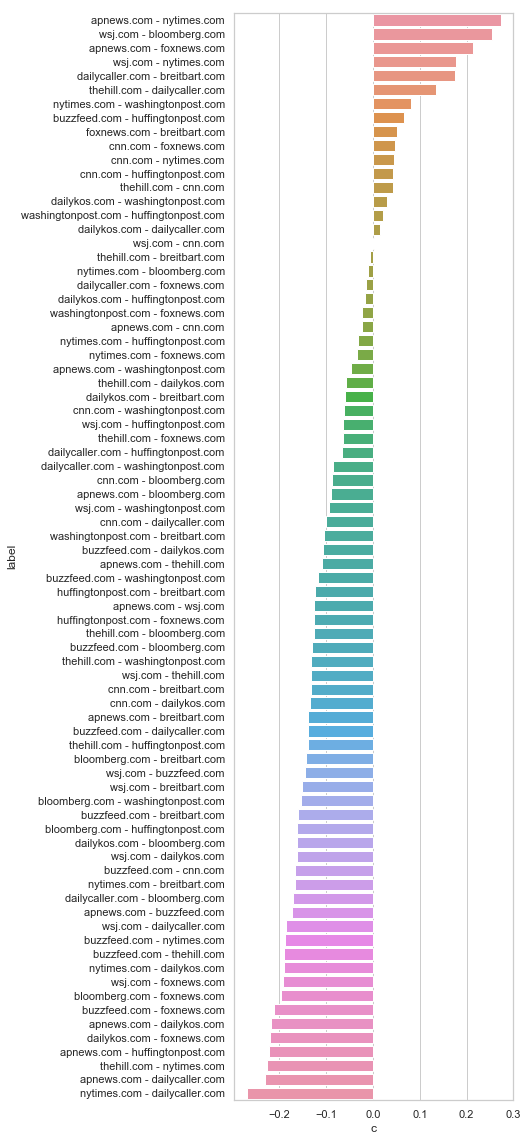

In [186]:
plt.figure(figsize=(5,20))
sns.barplot(x='c', y='label', data=df.sort_values('c', ascending=False))

# Spearman correlation

In [187]:
rows = []
for d1, d2 in tqdm(combinations(domains, 2)):
    c, _ = title_corr(d1, d2, stats.spearmanr)
    rows.append((d1, d2, c))

78it [01:00,  1.32it/s]


In [188]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'c'))
df['label'] = df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

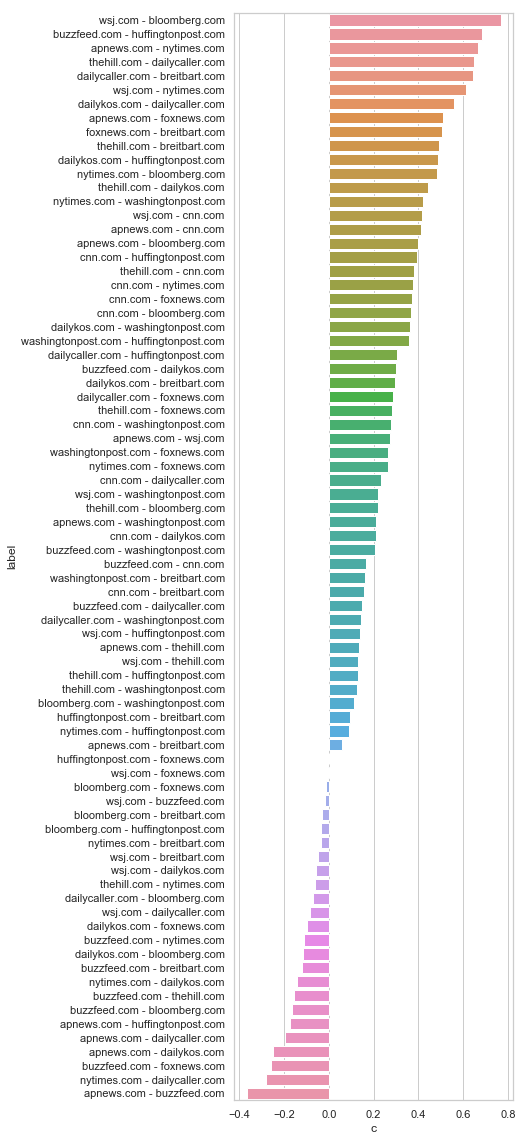

In [189]:
plt.figure(figsize=(5,20))
sns.barplot(x='c', y='label', data=df.sort_values('c', ascending=False))

In [199]:
preds[0]

OrderedDict([('title',
              'japan would boost missile defenses in record military budget'),
             ('label', 'apnews.com'),
             ('article_id', -728219345),
             ('first_ts', 1535708221),
             ('count', 1),
             ('p_nytimes.com', 0.10688054),
             ('p_washingtonpost.com', 0.070955426),
             ('p_thehill.com', 0.049153328),
             ('p_breitbart.com', 0.066575795),
             ('p_apnews.com', 0.36854294),
             ('p_buzzfeed.com', 0.000658829),
             ('p_wsj.com', 0.033946026),
             ('p_dailykos.com', 0.0012806719),
             ('p_dailycaller.com', 0.024619829),
             ('p_bloomberg.com', 0.10385104),
             ('p_huffingtonpost.com', 0.004261898),
             ('p_foxnews.com', 0.14974934),
             ('p_cnn.com', 0.019524354)])